## Estadistica Aplicada

Sesión 10  - 14 de septiembre

Francisco Humberto Villegas Reyna 1731722 Grupo043

In [1]:
#librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
##librerías especializadas
from lifelines  import  CoxPHFitter, ExponentialFitter, LogNormalFitter,WeibullFitter
import seaborn as sns

In [3]:
df_cancer= pd.read_csv("https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/cancer.csv")
df_cancer.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


## DATOS CANCER
    

Los datos constan de 228 observaciones y 10 variables/columnas. La descripción de las variables es la siguiente:
inst: código de institución\
**time (d1)**: tiempo de supervivencia en días\
**status (d2)**: estado de censura 1 = censurado, 2 = muerto\
**age (i1)**: Edad en años\
**sex (i2)**: Masculino = 1 Femenino = 2\
**ph.ecog (i3)**: puntuación de rendimiento ECOG según la calificación del médico. 0 = asintomático, 1 = sintomático pero completamente ambulatorio, 2 = en cama <50% del día, 3 = en cama > 50% del día pero no encamado, 4 = encamado\
**ph.karno (i4)**: puntuación de desempeño de Karnofsky (mala = 0; buena = 100) calificada por el médico\
**pat.karno (i4)**: puntuación de rendimiento de Karnofsky según la calificación del paciente\
**meal.cal (i5)**: Calorías consumidas en las comidas\
**wt.loss (i6)**: Pérdida de peso en los últimos seis meses


In [4]:
#Depuramos la base
df_cancer['status']=df_cancer['status']-1
df_cancer['sex']=df_cancer['sex']-1
#STATUS 0: CENSURA, 1:MUERTE
#SEX 0: HOMBRE, 1:MUJER

#Eliminamos la variable inst
df_cancer=df_cancer.drop('inst', axis=1)
df_cancer.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,1,74,0,1.0,90.0,100.0,1175.0,NaN
1,455,1,68,0,0.0,90.0,90.0,1225.0,15.0
2,1010,0,56,0,0.0,90.0,90.0,NaN,15.0
3,210,1,57,0,1.0,90.0,60.0,1150.0,11.0
4,883,1,60,0,0.0,100.0,90.0,NaN,0.0


In [5]:
#VERIFICAMOS QUE LAS VARIABLES SEAN NUMERICAS
df_cancer.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.ecog      float64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
dtype: object

In [6]:
#df_cancer['ph.ecog']=df_cancer["ph.ecog"].astype('int64')
#int(df_cancer['ph.ecog'])
#quedo pendiente hacer entero el ph.ecog
df_cancer.isnull().sum()

time          0
status        0
age           0
sex           0
ph.ecog       1
ph.karno      1
pat.karno     3
meal.cal     47
wt.loss      14
dtype: int64

In [7]:
#VAMOS A INPUTAR LOS MISSING VALUES CON EL PROMEDIO DE LA VARIABLE

##VALORES PERDIDOS HAY DOS OPCIONES, 1-IMPUTAR (ASIGNAR) VALORES, 2: ELIMINAR.
df_cancer['ph.karno']=df_cancer['ph.karno'].fillna(df_cancer['ph.karno'].mean())
media_patkarno = df_cancer['pat.karno'].mean()
media_cal = df_cancer['meal.cal'].mean()
media_loss = df_cancer['wt.loss'].mean()

df_cancer['pat.karno'] = df_cancer['pat.karno'].fillna(media_patkarno)
df_cancer['meal.cal'] = df_cancer['meal.cal'].fillna(media_cal)
df_cancer['wt.loss'] = df_cancer['wt.loss'].fillna(media_loss)
df_cancer.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,306,1,74,0,1.0,90.0,100.0,1175.000000,9.831776
1,455,1,68,0,0.0,90.0,90.0,1225.000000,15.000000
2,1010,0,56,0,0.0,90.0,90.0,928.779006,15.000000
3,210,1,57,0,1.0,90.0,60.0,1150.000000,11.000000
4,883,1,60,0,0.0,100.0,90.0,928.779006,0.000000


In [8]:
##eliminar missin values ph.ecog
df_cancer=df_cancer.dropna()

In [9]:
df_cancer['ph.ecog']=df_cancer['ph.ecog'].astype('int64')

In [10]:
df_cancer.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.ecog        int64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
dtype: object

In [11]:
##lifelines no acepta variables categoricas.
##lifelines solo admite dummies y continuas
## vamos a convertir ph.ecog en dummies
dummies=pd.get_dummies(df_cancer['ph.ecog'], prefix='ecog').astype(int)
dummies.head()

,ecog_0,ecog_1,ecog_2,ecog_3
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,0,1,0,0
4,1,0,0,0


In [12]:
dummies=dummies[['ecog_1','ecog_2']]
df_cancer=pd.concat([df_cancer,dummies], axis=1)

In [13]:
df_cancer.head()

,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
0,306,1,74,0,1,90.0,100.0,1175.000000,9.831776,1,0
1,455,1,68,0,0,90.0,90.0,1225.000000,15.000000,0,0
2,1010,0,56,0,0,90.0,90.0,928.779006,15.000000,0,0
3,210,1,57,0,1,90.0,60.0,1150.000000,11.000000,1,0
4,883,1,60,0,0,100.0,90.0,928.779006,0.000000,0,0


In [14]:
df_cancer=df_cancer.drop('ph.ecog',axis=1)

In [15]:
df_cancer.head()
df_cancer.isnull().sum()
df_cancer.dtypes

time           int64
status         int64
age            int64
sex            int64
ph.karno     float64
pat.karno    float64
meal.cal     float64
wt.loss      float64
ecog_1         int32
ecog_2         int32
dtype: object

In [16]:
##ESTADISTICA DESCRIPTIVA
df_cancer.describe()

,time,status,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ecog_1,ecog_2
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,306.264317,0.722467,62.458150,0.396476,82.034971,79.999413,927.474067,9.734118,0.497797,0.220264
std,210.532764,0.448771,9.092045,0.490246,12.240894,14.543193,358.375611,12.670492,0.501100,0.415341
min,5.000000,0.000000,39.000000,0.000000,50.000000,30.000000,96.000000,-24.000000,0.000000,0.000000
25%,168.500000,0.000000,56.000000,0.000000,80.000000,70.000000,768.000000,0.000000,0.000000,0.000000
50%,259.000000,1.000000,63.000000,0.000000,80.000000,80.000000,928.779006,8.000000,0.000000,0.000000
75%,399.000000,1.000000,69.000000,1.000000,90.000000,90.000000,1075.000000,15.000000,1.000000,0.000000
max,1022.000000,1.000000,82.000000,1.000000,100.000000,100.000000,2600.000000,68.000000,1.000000,1.000000


72% de los individuos murieron, el 39.6% son mujeres, el promedio de edad es de 62.4 años, el más joven tiene 39 años y elmayor tiene 82 años.. Los pacientes consideran su estado de salud peor de lo que realmete estan si bien en promedio perdieron peso, tambien existen observaciones que aumenatron de peso.

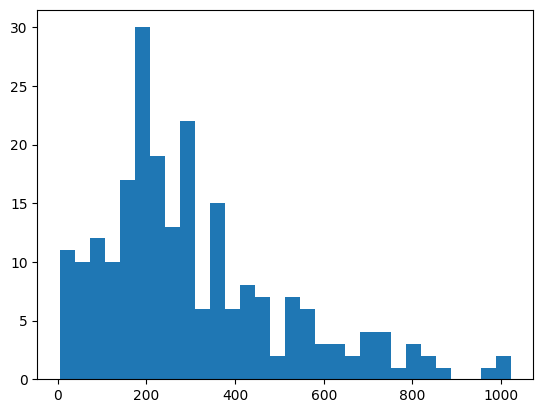

In [17]:
plt.hist(df_cancer['time'], bins=30);

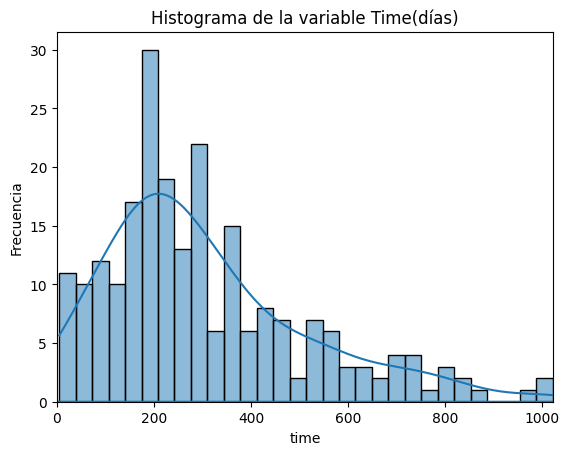

In [18]:
sns.histplot(df_cancer['time'], bins=30, kde=True)
sns.kdeplot(df_cancer['time'])
plt.xlim(0,1022)
plt.ylabel('Frecuencia')
plt.title('Histograma de la variable Time(días)');

In [20]:
##estimar el modelo
cph1=CoxPHFitter().fit(df_cancer,'time','status')
cph1.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 164
   partial log-likelihood = -726.94
         time fit was run = 2023-09-15 21:26:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.58       0.56       0.17            -0.92            -0.25                 0.40                 0.78
ph.karno    0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
ecog_1      0.56       1.74       0.24             0.09             1.02                 1.10                 2.77
ecog_2      1.08       2.94       0.37             0.35             1.80                 1.43                 6.08

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.37   0.17       2.54
sex           0.00 -3.41 <0.005      10.59
ph.karno      0.00  1.37   0.17       2.56
pat.karno     0.00 -1.82   0.07       3.87
meal.cal      0.00  0.11   0.92       0.13
wt.loss       0.00 -1.65   0.10       3.35
ecog_1        0.00  2.35   0.02       5.74
ecog_2        0.00  2.92 <0.005       8.15
---
Concordance = 0.65
Partial AIC = 1469.88
log-likelihood ratio test = 35.08 on 8 df
-log2(p) of ll-ratio test = 15.24

Las variables age, ph.karno, pat.karno, meal.cal, wt.loss no tienen efecto en el riesgo de morir de cáncer.


Las muheres tienen menos riesgo de morir de cáncer que los hombres, mujeres tienen 44% menos riesgo de morir de cáncer que los hombres [[1-0.56]*100].


Un ambulatorio tienen un 74% más riesgo de morir de cáncer que un asintomático.


Alguien que esta en cama menos del 50% del día (12 horas) tiene 194% más rieso de morir de cáncer en comparación de un asintomático.

In [21]:
cph1.check_assumptions(df_cancer,p_value_threshold=0.05)

# H0 : SE VIOLA EL SUPUESTO DE RIESGO PROP CTE

# HA : NO SE VIOLA EL SUPUESTO DE RIESGO PROPORCIONAL CONSTANTE

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
age       km              0.35 0.55      0.86
          rank            0.14 0.71      0.50
ecog_1    km              2.31 0.13      2.96
          rank            2.14 0.14      2.80
ecog_2    km              1.88 0.17      2.55
          rank            1.47 0.23      2.15
meal.cal  km              5.13 0.02      5.41
          rank            4.53 0.03      4.91
pat.karno km              0.26 0.61      0.71
          rank            0.21 0.65      0.62
ph.karno  km              4.76 0.03      5.10
          rank            4.13 0.04      4.57
sex       km              2.71 0.10      3.33
          rank            2.58 0.11      3.21
wt.loss   km              0.01 0.93      0.11
          rank            0.04 0.85      0.24



1. Variable 'ph.karno' failed the non-proportional test: p-value is 0.0292.

   Advice 1: the functional form of the variable 'ph.karno' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ph.karno' using pd.cut, and then specify it in
`strata=['ph.karno', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'meal.cal' failed the non-proportional test: p-value is 0.0235.

   Advice 1: the functional form of the variable 'meal.cal' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional

[]

Este modelo de Cox no cumple el supuesto de riesgo proporcional constante, debemos de utilizar AFT "modelo de riesgo acelerado"

In [25]:
##Para AFT debemos determinar primero si es Exponencial, Weibull o LogNormal
mexpo=ExponentialFitter().fit(df_cancer['time'],df_cancer['status'])
mweibull = WeibullFitter().fit(df_cancer['time'],df_cancer['status'])
mlogn= LogNormalFitter().fit(df_cancer['time'],df_cancer['status'])

In [26]:
##criterio AIC (menor=mejor)
mexpo.AIC_.round(2),mweibull.AIC_.round(2), mlogn.AIC_.round(2)

(2314.25, 2298.86, 2330.35)

El mejor modelo es el Weibull, por tanto es el que utilizaremos para el AFT

In [27]:
from lifelines import WeibullAFTFitter

In [29]:
weibullAFT = WeibullAFTFitter().fit(df_cancer,'time','status')
weibullAFT.print_summary()

<lifelines.WeibullAFTFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 227
number of events observed = 164
           log-likelihood = -1129.85
         time fit was run = 2023-09-15 21:43:59 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age        -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
        ecog_1     -0.40       0.67       0.17            -0.73            -0.08                 0.48                 0.93
        ecog_2     -0.80       0.45       0.26            -1.31            -0.29                 0.27                 0.75
        meal.cal   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        pat.karno   0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
        ph.karno   -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
        sex         0.42       1.52       0.12             0.18             0.66                 1.19                 1.93
        wt.loss     0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
        Intercept   6.82     915.17       0.88             5.09             8.55               161.74              5178.16
rho_    Intercept   0.33       1.40       0.06             0.21             0.45                 1.24                 1.58

                    cmp to     z      p   -log2(p)
param   covariate                                 
lambda_ age           0.00 -1.30   0.19       2.37
        ecog_1        0.00 -2.42   0.02       6.00
        ecog_2        0.00 -3.08 <0.005       8.92
        meal.cal      0.00 -0.03   0.98       0.03
        pat.karno     0.00  1.85   0.06       3.95
        ph.karno      0.00 -1.58   0.11       3.13
        sex           0.00  3.39 <0.005      10.49
        wt.loss       0.00  1.64   0.10       3.32
        Intercept     0.00  7.71 <0.005      46.20
rho_    Intercept     0.00  5.38 <0.005      23.68
---
Concordance = 0.65
AIC = 2279.70
log-likelihood ratio test = 35.16 on 8 df
-log2(p) of ll-ratio test = 15.29

**age** no se rechaza $H_0$, no tiene efecto sobre el tiempo promedio de morir de cáncer.


**ecog_1** sintomático ambulatorio se reduce su tiempo sobre el tiempo promedio de supervivencia de cáncer en 33% en comparación con un asintomático.